<a href="https://colab.research.google.com/github/Micahgs/Data-science-Assignments/blob/main/Decession_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score, roc_auc_score,
                           confusion_matrix, classification_report)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [9]:
# --- Load and Prepare Data ---
url = "https://raw.githubusercontent.com/Micahgs/DATA-science-asiignment-datasets/refs/heads/main/heart_disease.xlsx"
data = pd.read_excel(url, sheet_name=1)



In [10]:
# Data Cleaning
data['oldpeak'] = data['oldpeak'].fillna(data['oldpeak'].median())
categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
for col in categorical_cols:
    data[col] = data[col].astype(str)
data['fbs'] = data['fbs'].astype(int)
data['target'] = data['num'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# Features & Target
X = data.drop(['num', 'target'], axis=1)
y = data['target']
numerical_cols = ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'oldpeak']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# --- Build Pipeline ---
pipe = Pipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

In [14]:
# Hyperparameter Grid
param_grid = {
    'clf__max_depth': [3, 5, 7, 10, 15, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy'],
    'clf__class_weight': [None, 'balanced']
}


In [15]:
# Grid Search
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_




In [16]:
# --- Evaluate Model ---
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nBest Parameters:", grid_search.best_params_)
print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10}

Tuned Model Performance:
Accuracy: 0.7473
Precision: 0.7857
Recall: 0.7549
F1-Score: 0.7700
ROC-AUC: 0.7872

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        80
           1       0.79      0.75      0.77       102

    accuracy                           0.75       182
   macro avg       0.74      0.75      0.74       182
weighted avg       0.75      0.75      0.75       182



In [17]:
# --- Get Feature Names ---
# Fit preprocessor separately to access feature names
preprocessor.fit(X_train)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)

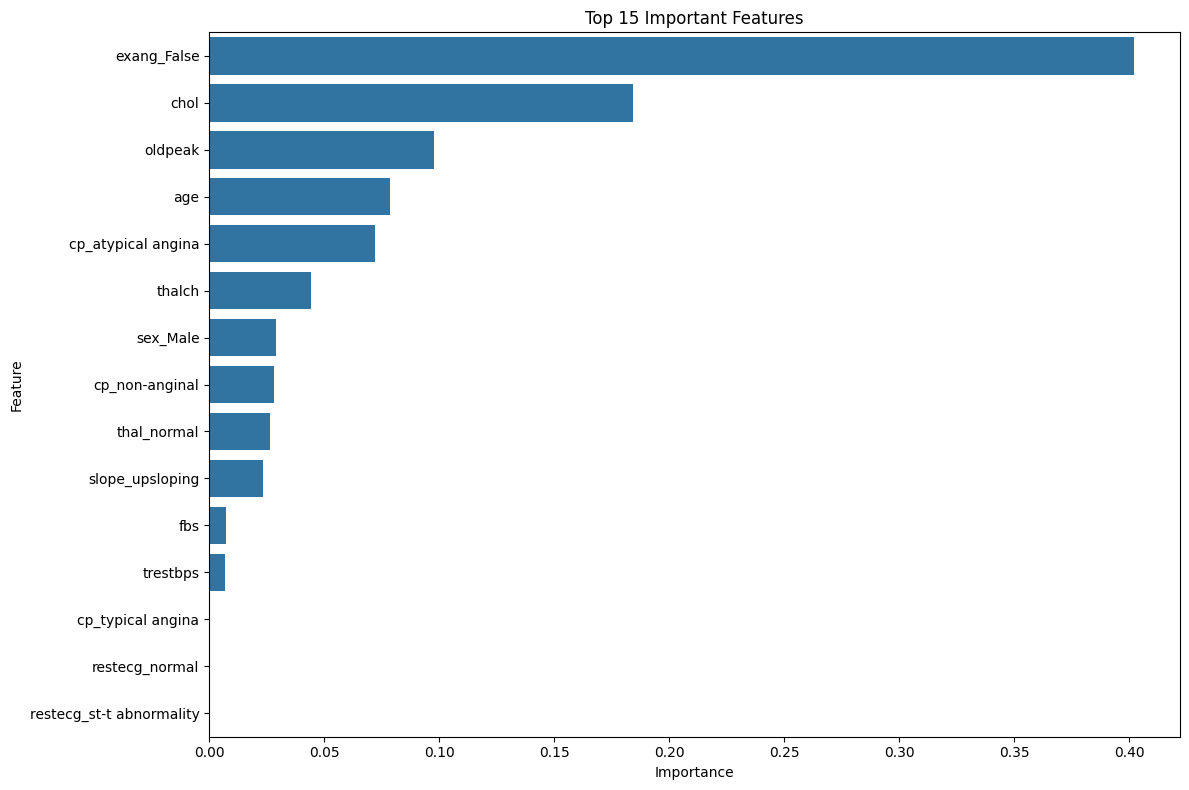

In [18]:
# --- Feature Importance ---
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_model.named_steps['clf'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()

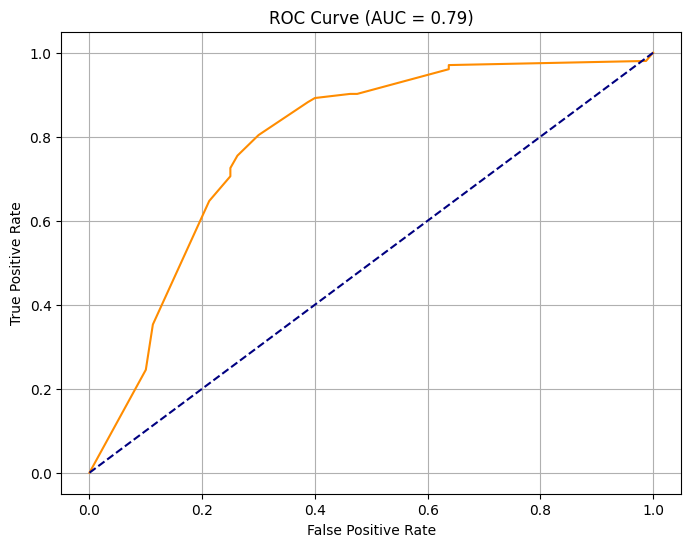


Top 5 Parameter Combinations:
                                                params  mean_test_score  \
68   {'clf__class_weight': None, 'clf__criterion': ...         0.830565   
176  {'clf__class_weight': 'balanced', 'clf__criter...         0.830565   
173  {'clf__class_weight': 'balanced', 'clf__criter...         0.829811   
65   {'clf__class_weight': None, 'clf__criterion': ...         0.829811   
174  {'clf__class_weight': 'balanced', 'clf__criter...         0.826302   

     std_test_score  
68         0.024198  
176        0.024198  
173        0.024007  
65         0.024007  
174        0.023722  


In [19]:
# --- ROC Curve ---
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.grid(True)
plt.show()

# --- Cross-Validation Results ---
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 Parameter Combinations:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']]
      .sort_values('mean_test_score', ascending=False).head())

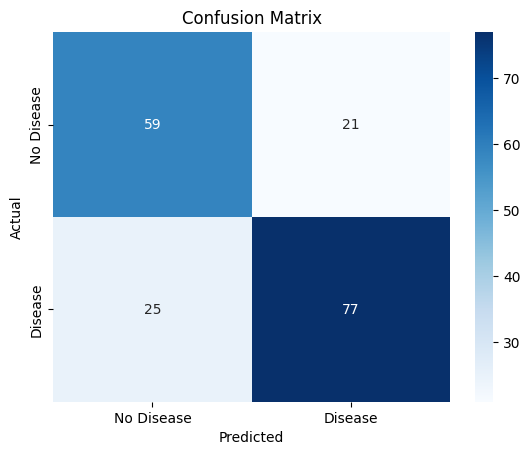

In [20]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Disease', 'Disease'],
           yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



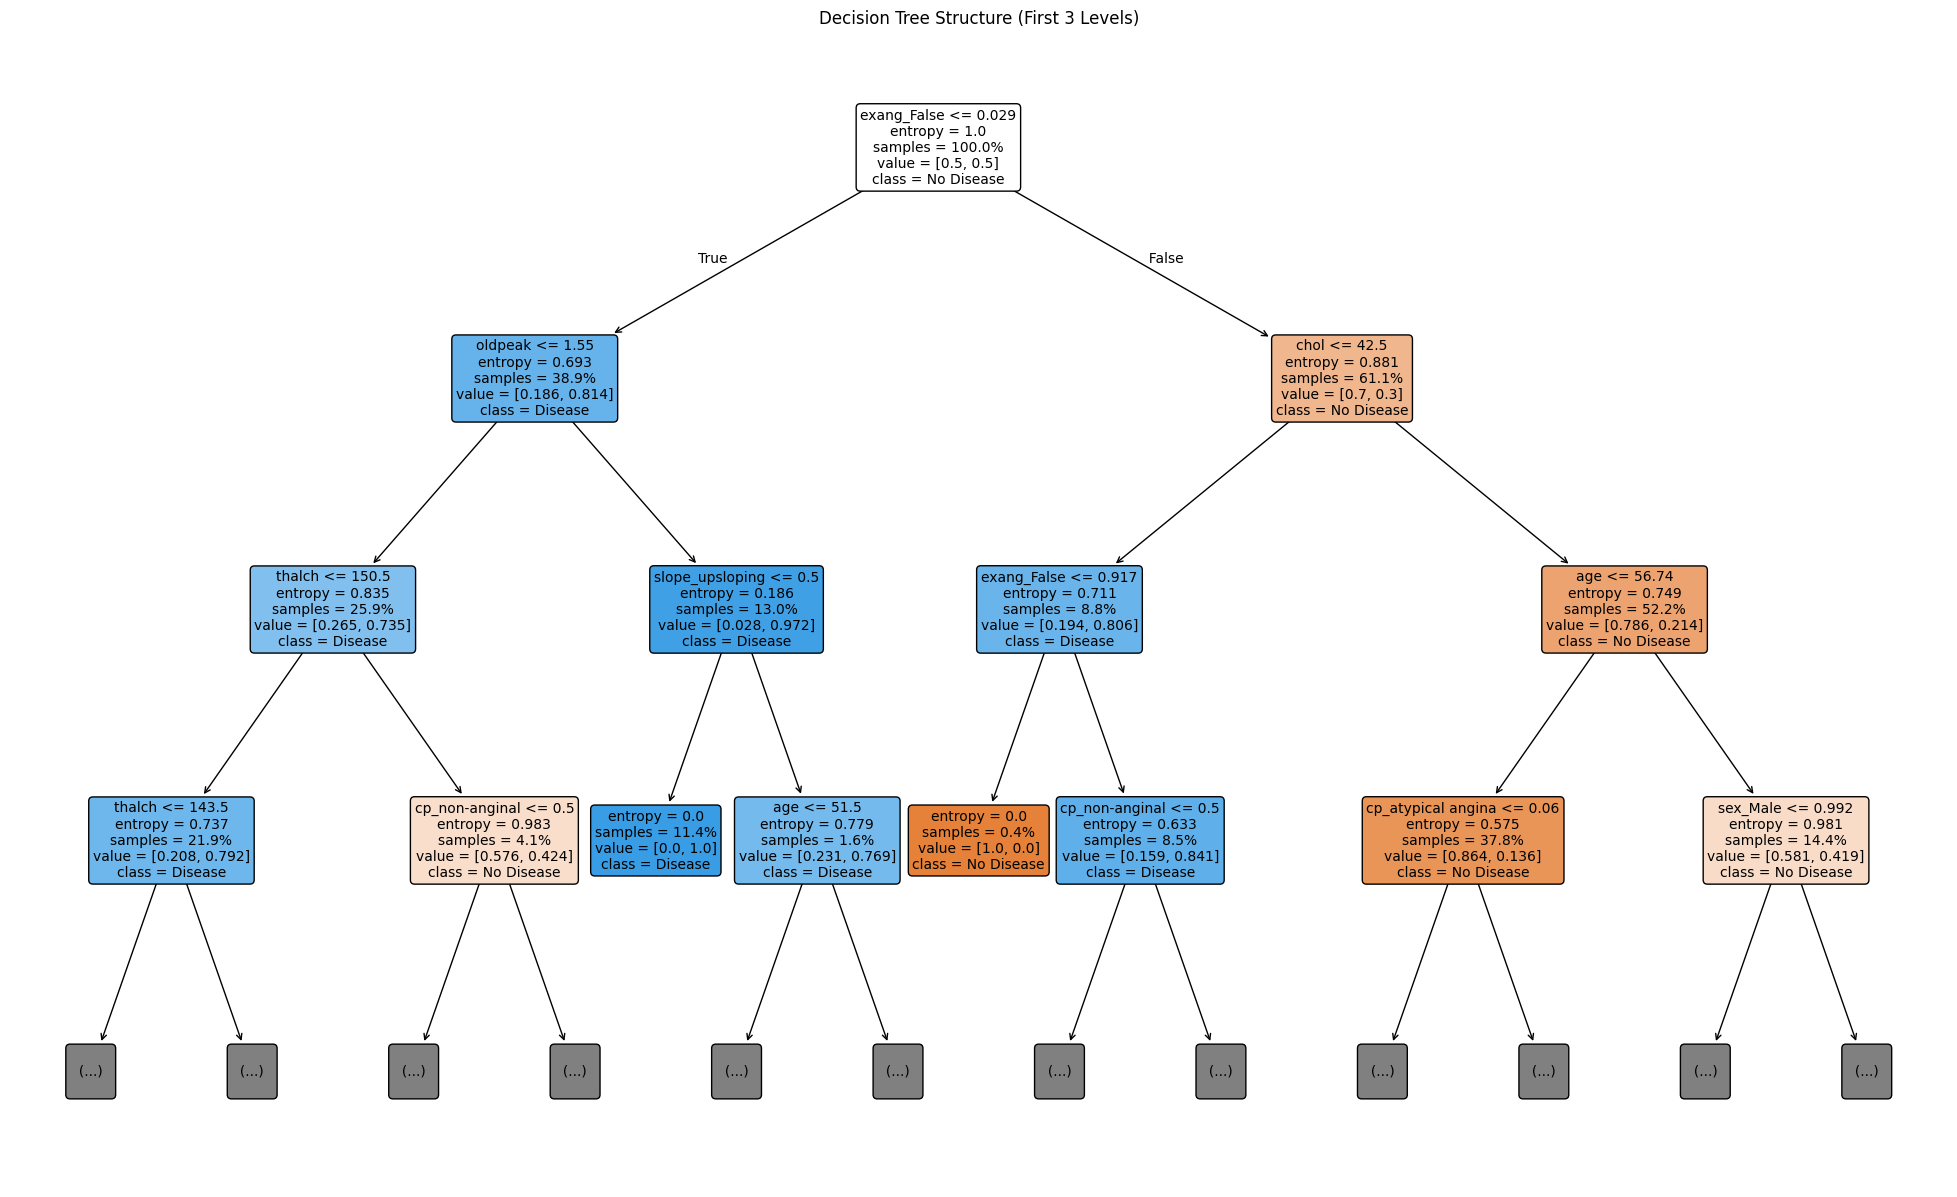

In [21]:
# --- Decision Tree Visualization ---
plt.figure(figsize=(25, 15))
plot_tree(best_model.named_steps['clf'], filled=True,
         feature_names=feature_names,
         class_names=['No Disease', 'Disease'],
         max_depth=3, proportion=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.show()


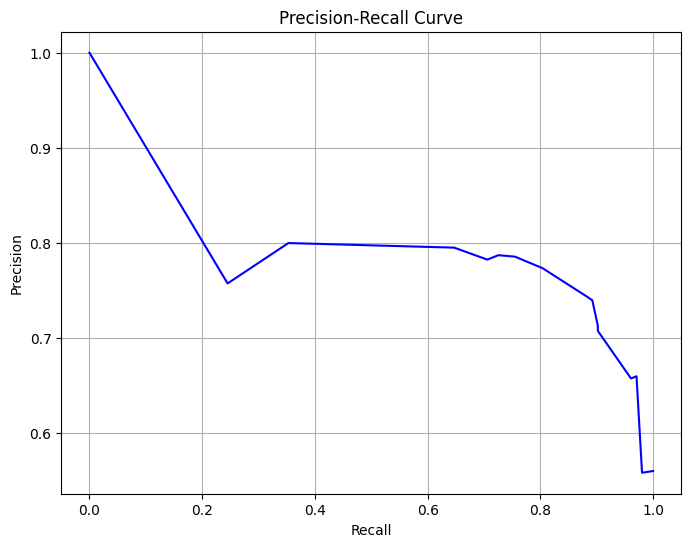

In [22]:

# --- Precision-Recall Curve ---
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# **1. Common Decision Tree Hyperparameters and Their Effects**
Decision tree models have several key hyperparameters that control their structure and performance:

max_depth: Limits how deep the tree can grow. A deeper tree captures more complex patterns but risks overfitting. In our heart disease model, the optimal depth was 5, balancing complexity and generalization.

min_samples_split: Sets the minimum number of samples required to split a node. Higher values (like our best value of 10) prevent overly specific splits, making the model more robust.

min_samples_leaf: Defines the minimum samples required in a terminal (leaf) node. We used 2, ensuring no leaf was too small while still allowing flexibility.

criterion: Determines how splits are evaluated (gini for Gini impurity or entropy for information gain). Our model performed best with entropy, which is often better for medical datasets where class probabilities matter.

class_weight: Adjusts for imbalanced classes. Interestingly, our model worked well both with and without class weighting, likely because SMOTE (oversampling) already balanced the dataset.

# **2. Label Encoding vs. One-Hot Encoding**

Label Encoding converts categorical values into numerical labels (e.g., "Male" → 0, "Female" → 1). It works well for ordinal data (categories with a natural order, like disease stages). However, it can mislead algorithms into assuming numerical relationships where none exist (e.g., if "Red"=0, "Green"=1, "Blue"=2, the model might incorrectly treat "Blue" as greater than "Red").

One-Hot Encoding creates binary columns for each category (e.g., "Male" → [1, 0], "Female" → [0, 1]). This avoids artificial ordinal relationships and is ideal for nominal data (categories without order). In our heart disease project, we used one-hot encoding for features like cp (chest pain type) and thal (thalassemia) because they had no meaningful ranking.

Why One-Hot for Our Model?
Decision trees split features independently, so one-hot encoding ensures each category is evaluated fairly. For example, "typical angina" and "asymptomatic" chest pain types got their own binary columns, letting the tree weigh them separately. The only exception was fbs (fasting blood sugar), a boolean we converted to 0/1 since it represented a true/false condition.